<a href="https://colab.research.google.com/github/Saravanan1718/Image-To-Text-Extraction-ML/blob/main/Final_ModelofImageToText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1:Import all the necessary packages for the model** 

In [ ]:
from __future__ import division
import numpy as np
import os
import glob
from random import *
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
# %matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from google.colab import drive


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

**Step 2:Uploading the Dataset to Google Drive for easy accessing**

In [ ]:
drive.mount('/content/gdrive')
d = {}
from subprocess import check_output
with open('/content/gdrive/My Drive/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer
print(len(d.keys()))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
1539


**Step 3: Preprocess the Data**

In [ ]:
tmp=[]
target_list = []
path_to_files = os.path.join('/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
# print(filename)
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))
img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files)
print(img_targets)


['/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/a01-000u-s00-00.png'
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/a01-000u-s00-01.png'
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/a01-000u-s00-02.png'
 ...
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/r06-143-s03-00.png'
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/r06-143-s04-00.png'
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/r06-143-s04-01.png']
['000' '000' '000' ... '635' '635' '635']


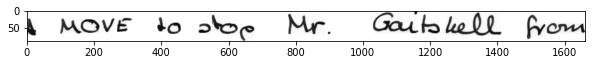

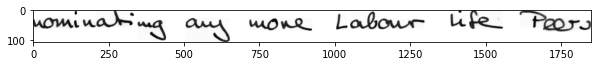

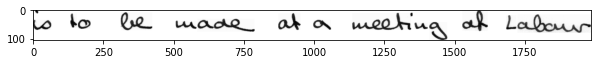

In [ ]:
# visualize the image data
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')


In [ ]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)
print(img_files[:10], img_targets[:10], encoded_Y[:10])


['/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/a01-000u-s00-00.png'
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/a01-000u-s00-01.png'
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/a01-000u-s00-02.png'
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/a01-000u-s00-03.png'
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/a01-000u-s01-00.png'
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/a01-000u-s01-01.png'
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/a01-000u-s01-02.png'
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/a01-000u-s01-03.png'
 '/content/gdrive/My Drive/1596236508_34370_46011_bundle_archive/data_subset/data_subset/a01-003u-s00-00.png'
 '/content

**Step 4: Dividing the dataset into train and test and validation sets**

In [ ]:
# Splitting of data into training and validation sets for cross validation with 4:1:1 ratio.
train_files, rem_files, train_targets, rem_targets = train_test_split(
    img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)
validation_files, test_files, validation_targets, test_targets = train_test_split(
    rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)
print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


**Defining Generator function **

In [ ]:
# Generator function for generating random crops from each sentence randomly cropping 113*113 patches from images
batch_size = 10
num_classes = 50
def generate_data(samples, target_files, batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]
            images = []
            targets = []
            for i in range(len(batch_samples)):
              batch_sample = batch_samples[i]
              batch_target = batch_targets[i]
              im = Image.open(batch_sample)
              cur_width = im.size[0]
              cur_height = im.size[1]
              # print(cur_width, cur_height)
              height_fac = 113 / cur_height
              new_width = int(cur_width * height_fac)
              size = new_width, 113
              imresize = im.resize((size), Image.ANTIALIAS) # Resize so height = 113 while keeping aspect ratio
              now_width = imresize.size[0]
              now_height = imresize.size[1]
# Generate crops of size 113x113 from this resized image and keep random 10% of crops
              avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113
# Pick random x%
              pick_num = int(len(avail_x_points)*factor)
# Now pick
              random_startx = sample(avail_x_points, pick_num)
              for start in random_startx:
                  imcrop = imresize.crop((start, 0, start+113, 113))
                  images.append(np.asarray(imcrop))
                  targets.append(batch_target)
# trim image to only see section with road
              X_train = np.array(images)
              y_train = np.array(targets)
#reshape X_train for feeding in later
              X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
#convert to float and normalize
              X_train = X_train.astype('float32')
              X_train /= 255
#One hot encode y
              y_train = to_categorical(y_train, num_classes)
              yield shuffle(X_train, y_train)



In [ ]:
# Generate data for training and validation
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

**Step 5 : Defining the model / network architecture**

In [ ]:
# A Keras Model is built. Summary of the model is printed below.
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image,[56,56])
# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
#model.add(Lambda(resize_image)) #resize images to allow for easy computation

#model.add(Lambda(lambda x: resize_image))
# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2')) #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters=128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3')) #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, name='dense1')) #1024

# model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64, name='dense2')) #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))
model.compile(optimizer= 'adam' , loss= 'binary_crossentropy', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 58, 58, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 58, 58, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 29, 29, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 29, 29, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 64)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 64)      

**Step 6: Training the model**

In [ ]:
# Training the model 

nb_epoch = 4

samples_per_epoch = 233
nb_val_samples = 62



from keras.callbacks import ModelCheckpoint
filepath="gdrive/My Drive/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]


history_object = model.fit_generator(train_generator, samples_per_epoch= samples_per_epoch,
                                     validation_data=validation_generator,
                                     nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, verbose=1, callbacks=callbacks_list)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=233, epochs=4, validation_steps=62)`



Epoch 1/4
233/233 [==============================] - 3672s 16s/step - loss: 0.0954 - accuracy: 0.9799 - val_loss: 0.1156 - val_accuracy: 0.9800

Epoch 00001: saving model to gdrive/My Drive/check-01-0.1156.hdf5
Epoch 2/4
233/233 [==============================] - 3798s 16s/step - loss: 0.0944 - accuracy: 0.9799 - val_loss: 0.0995 - val_accuracy: 0.9800

Epoch 00002: saving model to gdrive/My Drive/check-02-0.0995.hdf5
Epoch 3/4
233/233 [==============================] - 3805s 16s/step - loss: 0.0908 - accuracy: 0.9797 - val_loss: 0.0886 - val_accuracy: 0.9800

Epoch 00003: saving model to gdrive/My Drive/check-03-0.0886.hdf5
Epoch 4/4
233/233 [==============================] - 3811s 16s/step - loss: 0.0920 - accuracy: 0.9800 - val_loss: 0.0901 - val_accuracy: 0.9800

Epoch 00004: saving model to gdrive/My Drive/check-04-0.0901.hdf5


**Step 7: Saving the model**

In [ ]:
#Saving the model and weights into GDrive

from keras.models import model_from_json   
# serialize model to JSON
model_json = model.to_json()
with open("gdrive/My Drive/HTR Model/HTR_Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("gdrive/My Drive/HTR Model/HTR_model_weights.hdf5")
print("Saved model to GDrive")

Saved model to GDrive


In [ ]:
#Loading json and weights to recover model
import tensorflow as tf
json_file = open("gdrive/My Drive/HTR_Model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
l_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
l_model.load_weights("gdrive/My Drive/HTR_model_weights.hdf5")
print("Loaded model from Gdrive")

Loaded model from Gdrive


In [ ]:
model.save("gdrive/My Drive/HTR_model.hdf5")
print("Saved Keras Model")

Saved Keras Model


In [ ]:
#from keras.models import load_model
# load model
from tensorflow import keras
loaded_model = keras.models.load_model("gdrive/My Drive/HTR_model.hdf5", custom_objects=None, compile=True, options=None)
print("Loaded the Keras Model")

Loaded the Keras Model


In [ ]:
print(loaded_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_2 (ZeroPaddi  (None, 115, 115, 1)      0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 58, 58, 32)        832       
                                                                 
 activation_12 (Activation)  (None, 58, 58, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 29, 29, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 64)        18496     
                                                                 
 activation_13 (Activation)  (None, 29, 29, 64)        0         
                                                      

**Step 8: Testing the model**

In [ ]:
#model.load_weights('gdrive/My Drive/check-04-0.0901.hdf5')
scores = model.evaluate_generator(test_generator,280) 
print("Accuracy = ", scores[1])

Accuracy =  0.9174939393997192


**Step 9: Prediction**

In [ ]:
images = []
for filename in test_files[:50]:
    im = Image.open(filename)
    cur_width = im.size[0]
    cur_height = im.size[1]

   
    height_fac = 113 / cur_height

    new_width = int(cur_width * height_fac)
    size = new_width, 113

    imresize = im.resize((size), Image.ANTIALIAS)  
    now_width = imresize.size[0]
    now_height = imresize.size[1]


    avail_x_points = list(range(0, now_width - 113 ))

    
    factor = 0.1
    pick_num = int(len(avail_x_points)*factor)
    
    random_startx = sample(avail_x_points,  pick_num)

    for start in random_startx:
        imcrop = imresize.crop((start, 0, start+113, 113))
        images.append(np.asarray(imcrop))
        
    X_test = np.array(images)
    
    X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
   
    X_test = X_test.astype('float32')
    X_test /= 255
    shuffle(X_test)

print(X_test.shape)

(6351, 113, 113, 1)


In [ ]:
predictions = loaded_model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
199/199 [==============================] - 16s 81ms/step
(6351, 50)
6351


In [ ]:
writer_number = 18
total_images =10
counter = 0
for i in range(len(predicted_writer)//10):
    if predicted_writer[i] == writer_number:
        image = X_test[i].squeeze()
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap ='gray')

In [ ]:
writer_number = 18
total_images =10
counter = 0
print("Saravanan R")
for i in range(len(predicted_writer)//10):
    if predicted_writer[i] == writer_number:
        image = X_test[i].squeeze()
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap ='gray')
        plt.show()

Saravanan R


**Step 10: Plotting the loss and accuracy **

In [ ]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
acc = history_object.history['accuracy']
val_acc = history_object.history['val_accuracy']
loss = history_object.history['loss']
val_loss = history_object.history['val_loss']
epochs = range(1,len(loss)+1)

**Loss vs Epoch Graph**

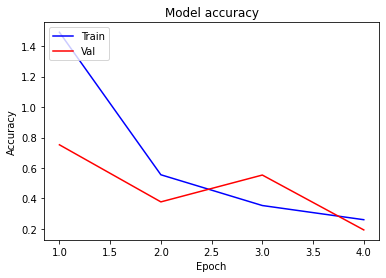

In [ ]:
plotgraph(epochs, loss, val_loss)

**Accuracy vs Epoch Graph**

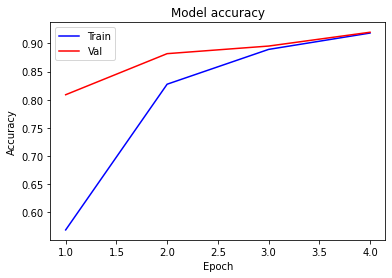

In [ ]:
plotgraph(epochs, acc, val_acc)

**The End**